In [1]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

have a 2d gaussian distribution with 0 mean and I covariance matrix. 
add a 3rd feature whos value is (1,2,3) if normal and (18, 91, 20) if outlier.

In [2]:
np.random.seed(20)

# Parameters
num_groups = 100
num_points_per_group = 30
num_features = 3  # Two Gaussian features + one label
num_normal = 97
num_anomalous = 3

# Generate data
dataset = []
for i in range(num_groups):
    if i < num_normal:
        label = np.random.choice([1, 2, 3])  
    else:
        label = np.random.choice([18, 19, 20]) 
    points = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=num_points_per_group)
    feature_3 = np.full((num_points_per_group, 1), label)  # Feature 3 as a column
    group_data = np.hstack([points, feature_3]) 
    dataset.append(group_data)

# Convert dataset into a 3D NumPy array
final_dataset = np.array(dataset)  

In [3]:
final_dataset

array([[[-9.50443117e-01,  1.50227571e+00,  3.00000000e+00],
        [ 2.12601055e+00,  2.49155430e-01,  3.00000000e+00],
        [-6.20642157e-01, -8.34532935e-01,  3.00000000e+00],
        ...,
        [-2.21909547e+00, -7.49404606e-01,  3.00000000e+00],
        [ 4.86063175e-01, -1.76752659e+00,  3.00000000e+00],
        [ 2.22710846e-01, -7.05439508e-01,  3.00000000e+00]],

       [[-5.48331454e-01,  2.97280923e-01,  3.00000000e+00],
        [-6.00914445e-01,  9.10865062e-01,  3.00000000e+00],
        [ 1.43127170e+00,  2.60349438e-01,  3.00000000e+00],
        ...,
        [ 6.83495390e-01,  9.26002960e-01,  3.00000000e+00],
        [ 2.27227061e-01, -1.96859016e-01,  3.00000000e+00],
        [-6.39854207e-01, -1.33643179e-02,  3.00000000e+00]],

       [[-3.14030161e-01, -9.55774320e-01,  1.00000000e+00],
        [ 4.41255095e-01, -2.07323620e-02,  1.00000000e+00],
        [ 4.15292839e-01, -6.92940082e-02,  1.00000000e+00],
        ...,
        [-8.67849560e-01,  5.16497796e-01,

In [4]:
classifier = OneClassSMMClassifier(nu=0.08)

In [5]:
classifier.fit(final_dataset)

In [6]:
decision, y_pred = classifier.predict(final_dataset)

[2.83187897 2.83187931 2.83187888 2.83187932 2.83058359 2.8318793
 2.83187889 2.79335117 2.83187932 2.80588681 1.89609457 1.8419884
 2.27030455]


In [7]:
count_neg_1 = np.count_nonzero(y_pred == -1)
count_pos_1 = np.count_nonzero(y_pred == 1)

print(f"Count of -1: {count_neg_1}")
print(f"Count of +1: {count_pos_1}")

Count of -1: 3
Count of +1: 97


In [8]:
decision

array([ 0.223595  ,  0.31227844,  0.1963895 ,  0.25717913,  0.23544417,
        0.23957295,  0.19638984,  0.27327301,  0.22475466,  0.30085008,
        0.68183212,  0.27397419,  0.66231734,  0.2365878 ,  0.24237851,
        0.26230539,  0.19638941,  0.65838144,  0.28897748,  0.31828   ,
        0.30115478,  0.62509382,  0.64643341,  0.28568785,  0.19638985,
        0.24474226,  0.21022512,  0.59385861,  0.65727088,  0.23432001,
        0.27067978,  0.32411093,  0.31323537,  0.66784501,  0.29454014,
        0.63132991,  0.22077964,  0.64858841,  0.19509412,  0.25145888,
        0.27201315,  0.55188536,  0.23951422,  0.19638983,  0.63495291,
        0.6397342 ,  0.25507713,  0.65093135,  0.29259017,  0.59143611,
        0.60321236,  0.26617886,  0.62323683,  0.66684594,  0.2447111 ,
        0.24483211,  0.6843275 ,  0.19638943,  0.25550575,  0.2752268 ,
        0.57662157,  0.19996046,  0.21241229,  0.2801318 ,  0.25275685,
        0.65094602,  0.1578617 ,  0.25847805,  0.30679106,  0.25

In [9]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[97, 98, 99]

In [10]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=final_dataset, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=final_dataset, num_coalitions=2**final_dataset[0].shape[1])

c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


In [11]:
shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [12]:
len(shapley_values.T)

100

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


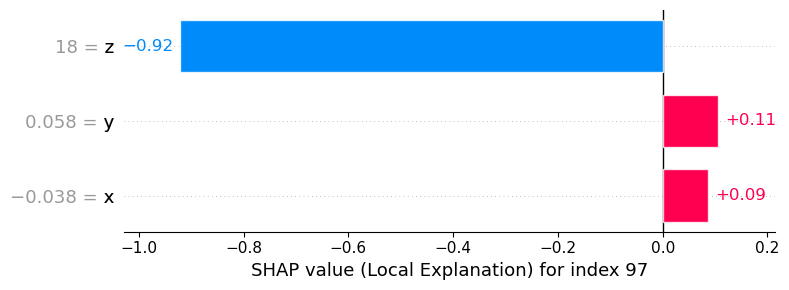

In [13]:
from src.utils.visualisation.deterministic_values import global_explanation_bar_plot, local_explanation_bar_plot

local_explanation_bar_plot(shapley_values.T, 97, feature_names=['x', 'y', 'z'], datasets=final_dataset)

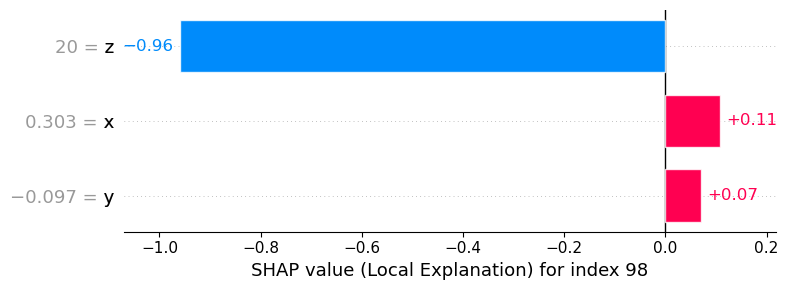

In [14]:
local_explanation_bar_plot(shapley_values.T, 98, feature_names=['x', 'y', 'z'], datasets = final_dataset)

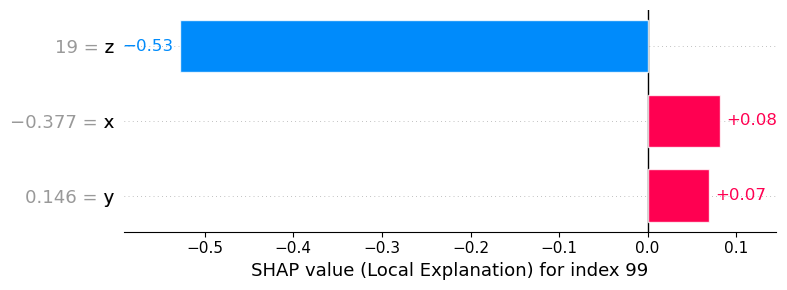

In [15]:
local_explanation_bar_plot(shapley_values.T, 99, feature_names=['x', 'y', 'z'], datasets=final_dataset)

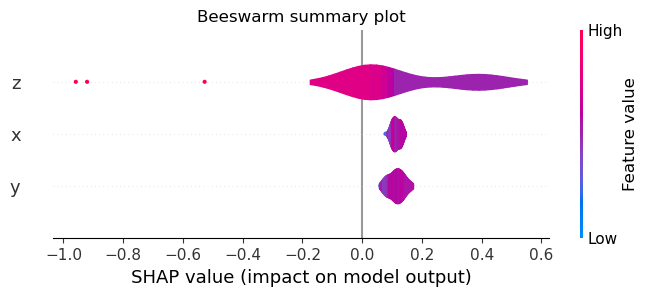

In [16]:
from src.utils.visualisation.deterministic_values import summary_explanation_plot
summary_explanation_plot(shapley_values=shapley_values.T, feature_names=['x', 'y', 'z'], datasets=final_dataset)

Feature z has the highest value in both the outliers which is the expected behaviour

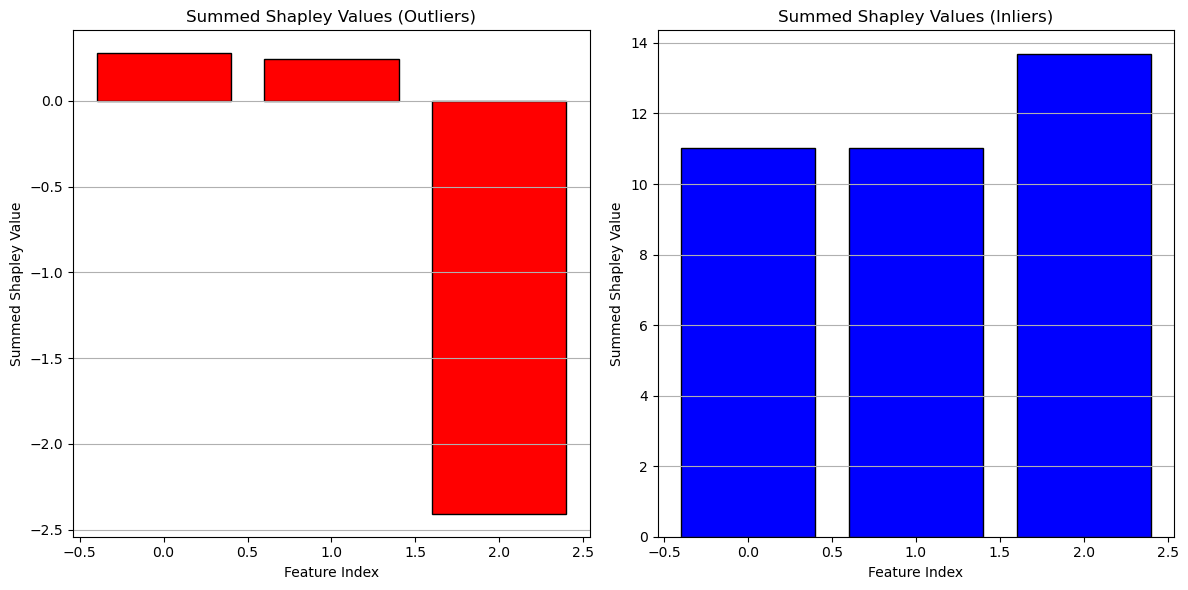

In [17]:
inlier_indices = [i for i in range(shapley_values.shape[1]) if i not in outlier_indices]

summed_outlier_shapley = shapley_values[:, outlier_indices].sum(dim=1).numpy()
summed_inlier_shapley = shapley_values[:, inlier_indices].sum(dim=1).numpy()

# Plot histogram
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Outlier Shapley Values
ax[0].bar(range(len(summed_outlier_shapley)), summed_outlier_shapley, color='red', edgecolor='black')
ax[0].set_title('Summed Shapley Values (Outliers)')
ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Summed Shapley Value')
ax[0].grid(True, axis='y')

# Inlier Shapley Values
ax[1].bar(range(len(summed_inlier_shapley)), summed_inlier_shapley, color='blue', edgecolor='black')
ax[1].set_title('Summed Shapley Values (Inliers)')
ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Summed Shapley Value')
ax[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

Even in the case of inliers, feature z is telling us the reasons for the prediction

The most influential feature is the feature 3, which is causing the outlier prediction

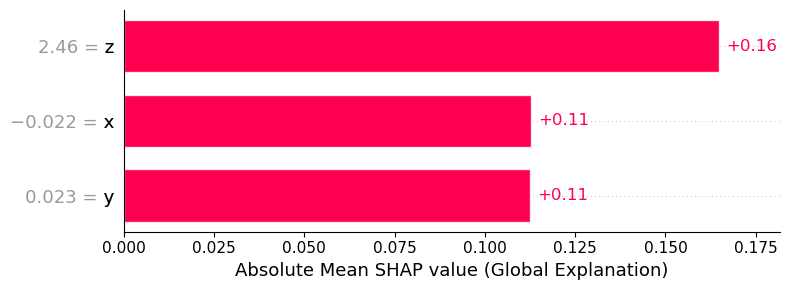

In [18]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_explanation_bar_plot(mean_abs_shap_values, feature_names=['x', 'y', 'z'], datasets=final_dataset)

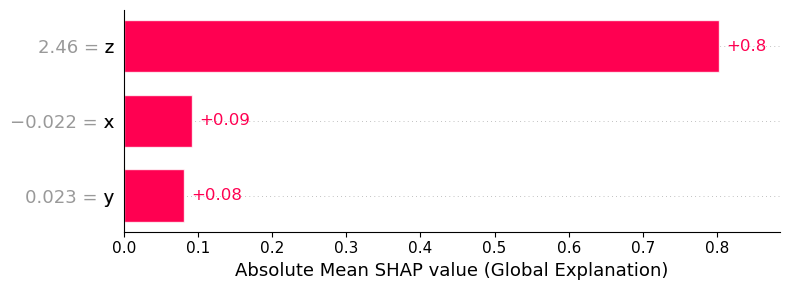

In [19]:
selected_shap_values = shapley_values[:,outlier_indices]
mean_abs_shap_values_outlier = np.abs(selected_shap_values).mean(axis=1) 
global_explanation_bar_plot(mean_abs_shap_values_outlier, feature_names=['x', 'y', 'z'], datasets= final_dataset)